## Functions

In [11]:
transformations = {
    0: lambda x: ['Black', 'White'][x],         
    1: lambda x: ['No', 'Yes'][x],              
    2: lambda x: ['No', 'Yes'][x],              
    3: lambda x: ['No', 'Yes'][x],              
    4: lambda x: ['No', 'Married'][x],          
    5: lambda x: ['No', 'Yes'][x],              
    6: lambda x: ['No', 'Yes'][x],              
    7: lambda x: ['No', 'Yes'][x],              
    8: lambda x: ['No', 'Yes'][x],              
    9: lambda x: ['Female', 'Male'][x],
    10: lambda x: x,
    11: lambda x: x,
    12: lambda x: x,                                  
    13: lambda x: x,
    14: lambda x: x,
    15: lambda x: x,
    16: lambda x: ['No more crimes', 'Re-arrested'][x]            
}

In [12]:
from anchor import utils

from tabulate import tabulate
import time
import csv
import copy

def get_categorical_names(data, categorical_names):
    ret = copy.deepcopy(data)
    for i, x in enumerate(data):
        ret[i] = categorical_names[i][x]
    return ret

def get_trg_sample(index, dataset, dataset_name, dataset_folder, write_file=False):
    
    print('Index: ', index)
    trg = dataset.test[index]
    label = dataset.labels_test[index]

    int_list = list(int(x) for x in trg)
    str_list = get_categorical_names(int_list, dataset.categorical_names)
    if dataset_name == 'recidivism':
        str_list = [str(transformations[i](int(x))) if x.isnumeric() else x for i, x in enumerate(str_list)]
    
    str_list = [x + ' (%d)' % int(int_list[i]) if not x.isnumeric() else x for i, x in enumerate(str_list)]
    
    trg_data = list(zip(dataset.feature_names, str_list))
    if dataset_name == 'recidivism':
        label_name = ['No more crimes', 'Re-arrested'][label]
    else:
        label_name = ['<=50K', '>50K'][label]
    trg_data.append([dataset.class_target, label_name + ' (%d)' % label])

    print('Prediction:', dataset.class_names[rf.predict(trg.reshape(1, -1))[0]])
    print('True:      ', dataset.class_names[dataset.labels_test[index]])
    print(tabulate(trg_data))
    if write_file:
        with open('img/%s/%05d-instance.csv' % (dataset_name, index), 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows([['feature', 'value']])
            writer.writerows(trg_data)
    return trg, label

In [13]:
from lime import explanation
from lime import lime_tabular

def lime_original(trg, pred_label):
    lime_explainer = lime_tabular.LimeTabularExplainer(
        dataset.train,
        feature_names=dataset.feature_names,
        class_names=dataset.class_names,
        discretize_continuous=False)
    lime_exp = lime_explainer.explain_instance(
        trg, rf.predict_proba, num_features=5, top_labels=1)
    # lime_exp.show_in_notebook(show_table=True, show_all=True)
    weights = [0] * len(dataset.feature_names)
    for t in lime_exp.local_exp[pred_label]:
        weights[t[0]] = t[1] * (pred_label * 2 - 1)
    plot_weights(weights, dataset.feature_names)

In [14]:
from anchor import anchor_tabular

def anchor_original(trg, threshold=0.85):
    anchor_explainer = anchor_tabular.AnchorTabularExplainer(
        dataset.class_names,
        dataset.feature_names,
        dataset.train,
        dataset.categorical_names)
    anchor_exp = anchor_explainer.explain_instance(
        trg, rf.predict, threshold)

    print('Threshold:  %.2f' % threshold)
    # print('Prediction:', anchor_explainer.class_names[rf.predict(trg.reshape(1, -1))[0]])
    print('Anchor:     %s' % (' AND '.join(anchor_exp.names())))
    print('Precision:  %.2f' % anchor_exp.precision())
    print('Coverage:   %.2f' % anchor_exp.coverage())

In [15]:
import newlime_base
import newlime_tabular

# display
import matplotlib.pyplot as plt
    
import importlib
importlib.reload(newlime_base)
importlib.reload(newlime_tabular)

def new_lime(trg, dataset, threshold, epsilon, beam_size, my_verbose):
    anchor_explainer = newlime_tabular.NewLimeTabularExplainer(
        dataset.class_names,
        dataset.feature_names,
        dataset.train,
        dataset.categorical_names)
    anchor_exp, surrogate_model = anchor_explainer.explain_instance(
        trg, rf.predict, threshold=threshold, epsilon=epsilon, beam_size=10, my_verbose=my_verbose)
    names = anchor_exp.names()
    multiline_names = []
    max_i = int(len(names) / 3)
    for i in range(max_i):
        triple = [names[i * 3], names[i * 3 + 1], names[i * 3 + 2]]
        multiline_names.append(' AND '.join(triple))
    if len(names) != max_i* 3:
        multiline_names.append(' AND '.join(names[max_i * 3:]))
    print(names)
    plot_weights(
        list(surrogate_model['LogisticRegression'].weights.values()),
        dataset.feature_names,
        ' AND \n'.join(multiline_names),
        anchor_exp.precision(),
        anchor_exp.coverage()
    )

In [16]:
def plot_weights(weights, feature_names, anchor=None, precision=None, coverage=None):
    print(weights)
    features = feature_names
    values = weights
    abs_values = [abs(x) for x in values]
    _, sorted_features, sorted_values = zip(*sorted(zip(abs_values, features, values), reverse=False)[-5:])
    plt.figure()
    color = ['#32a852' if sorted_values[i] > 0 else '#cf4529' for i in range(len(sorted_values))]
    plt.barh(sorted_features, sorted_values, color=color)
    anchor_str = ''
    
    if anchor != None:
        plt.title('%s\nwith Precision %.3f and Coverage %.3f' % (anchor, precision, coverage))
    for i in range(len(sorted_features)):
        plt.text(sorted_values[i], sorted_features[i], round(sorted_values[i], 5))
    plt.show

## Generating Explanations

In [17]:
dataset_folder = 'datasets/'
# dataset_name = 'recidivism'
dataset_name = 'adult'
# dataset_name = 'diabetes'
# dataset_name = 'default'
# dataset_name = 'lending'

dataset = utils.load_dataset(
    dataset_name, balance=True, dataset_folder=dataset_folder, discretize=True)

print(dataset.train.shape[0])
print(dataset.test.shape[0])
print(dataset.train.shape[0] + dataset.test.shape[0])

12545
1569
14114


In [18]:
import sklearn.ensemble

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
rf.fit(dataset.train, dataset.labels_train)

print('Train', sklearn.metrics.accuracy_score(
    dataset.labels_train, rf.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(
    dataset.labels_test, rf.predict(dataset.test)))

Train 0.9350338780390594
Test 0.8489483747609943


In [19]:
import random

i = random.randint(10, dataset.test.shape[0])

# adult
# 730, 956, 1196, 1522
# i = 1443 # --- Capital Gain = 2
i = 0

# recidivism
# i = 266
# i = 599

trg, trg_label = get_trg_sample(i, dataset, dataset_name, dataset_folder)

Index:  0
Prediction: b'>50K'
True:       b'>50K'
--------------  --------------------------
Age             28.00 < Age <= 37.00 (1)
Workclass       Private (4)
Education       Bachelors (9)
Marital Status  Married-civ-spouse (2)
Occupation      Sales (12)
Relationship    Husband (0)
Race            White (4)
Sex             Male (1)
Capital Gain    0
Capital Loss    0
Hours per week  Hours per week > 45.00 (2)
Country         United-States (39)
Income          >50K (1)
--------------  --------------------------


[0.04904508289103098, 0, 0.03529517481376101, -0.05485673860133381, 0, -0.06234039423837747, 0, 0, 0, 0, 0.05623960538626939, 0]


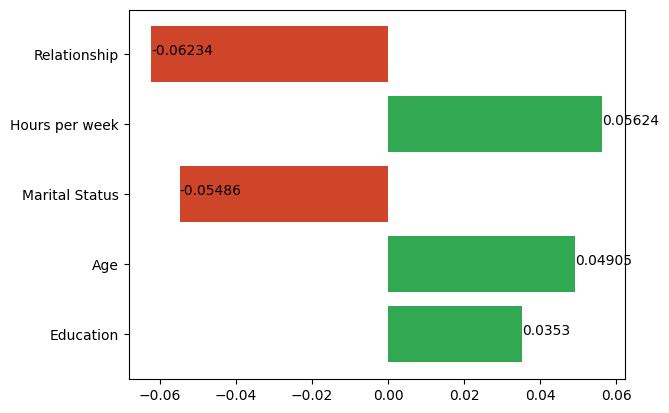

In [20]:
lime_original(trg, rf.predict([dataset.test[i]])[0])

write_file = False
if write_file:
    img_file = 'img/%s/%05d-LIME.png' % (dataset_name, i)
    plt.savefig(img_file, bbox_inches='tight')

[(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,)]
0.719
0.9018
0.2244
0.1048
0.51
0.9337
0.6705
0.5831
0.2639
0.2049
202310051450
[0.9337]
['Capital Loss = 0']
[0.034660400158408794, 0.006900022915285187, 0.01105092616824382, -0.028698966521093806, 0.012370485745219574, -0.029342574703745603, 0.008902540443456553, 0.025383249972787025, 0.029499913214056844, 0.0, 0.026673595951768294, 0.0020455324555855373]
[(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,)]
0.7228
0.2327
0.9061
0.9347
0.6672
0.1141
0.5165
0.8739
0.2713
0.202
[(3, 4), (4, 9), (3, 7), (4, 6), (3, 10), (5, 7), (0, 2), (5, 10), (8, 9), (0, 5), (1, 6), (0, 8), (2, 5), (2, 11), (1, 9), (0, 11), (1, 3), (2, 8), (9, 11), (6, 11), (7, 10), (6, 8), (4, 5), (3, 9), (5, 6), (4, 8), (3, 6), (5, 9), (4, 11), (8, 11), (0, 1), (0, 7), (2, 4), (1, 2), (0, 4), (0, 10), (2, 7), (1, 5), (1, 11), (9, 10), (2, 10), (1, 8), (10, 11), (7, 9), (6, 7), (6, 10), (4, 7), (3, 5), (3, 11), (4, 10), (5

ValueError: not enough values to unpack (expected 3, got 0)

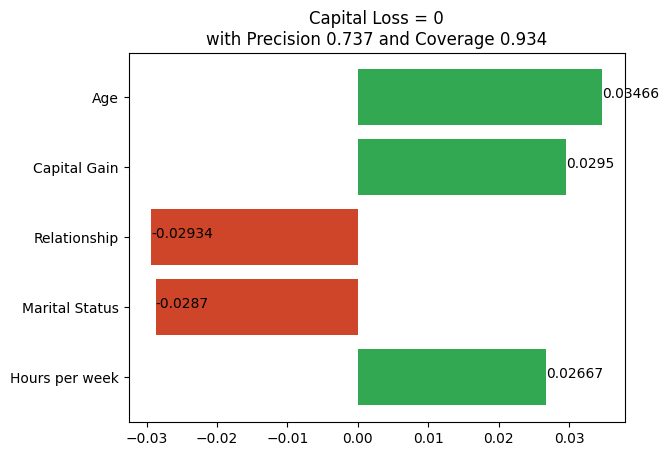

In [36]:
import importlib
importlib.reload(newlime_base)
importlib.reload(newlime_tabular)
write_file = False

for t in [0.70, 0.80, 0.90]:
    new_lime(trg, dataset, threshold=t, beam_size=1, epsilon=0.1, my_verbose=True)
    if write_file:
        img_file = 'img/%s/%05d-%03d.png' % (dataset_name, i, t * 100)
        plt.savefig(img_file, bbox_inches='tight')

In [ ]:
i

In [ ]:
anchor_original(trg, threshold=0.80)